# Figures 8 & S10

Neurophysiological differentiation vs. stimulus properties

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb

import analysis
from analysis import UNSCRAMBLED_SCRAMBLED
from load import load_stimulus_movie
from metadata import STIMULUS_METADATA

In [2]:
OUTPUT_DIR = Path("figures")

## Set up R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(broom)

## Load data

In [5]:
data = (
    pd.read_parquet("results/main.parquet")
    .merge(
        pd.read_parquet("results/stimulus_properties.parquet"),
        on='stimulus'
    )
)

In [6]:
# Only L2/3 of AL & AM
data = data.loc[
    (data["layer"] == "L2/3") &
    data["area"].isin(["AL", "AM"])
]

In [7]:
response = "log(normalized differentiation)"

## Plotting function

In [8]:
def plot_stimulus_property(data, x, y, fig=None, ax=None):
    # Average by stimulus
    data = data.groupby("stimulus").mean().reset_index()
    
    if fig is None and ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))

    ax = sb.scatterplot(
        data=data,
        x=x,
        y=y,
        edgecolor=None,
        color="#555",
        marker="o",
        s=85,
        ax=ax,
    )
    
    if x == "mean luminance":
        ax.set_xlim(0, 255)
        ax.set_xticks([0, 64, 128, 192, 256])
    
    ax.set_xlabel("\n" + x.replace("_", " "))
    ax.set_ylabel("neurophysiological differentiation\n")

    # Add annotations
    annotations = [
        ax.text(
            row[x],
            row[y],
            row["stimulus"],
            size="small",
        )
        for idx, row in data.iterrows()
    ]

    return fig, ax

## Figure 8

In [9]:
x = "log(stimulus differentiation)"

In [10]:
y = "log(normalized differentiation)"

PosixPath('figures/fig-8/nd_vs_stimulus_differentiation.svg')

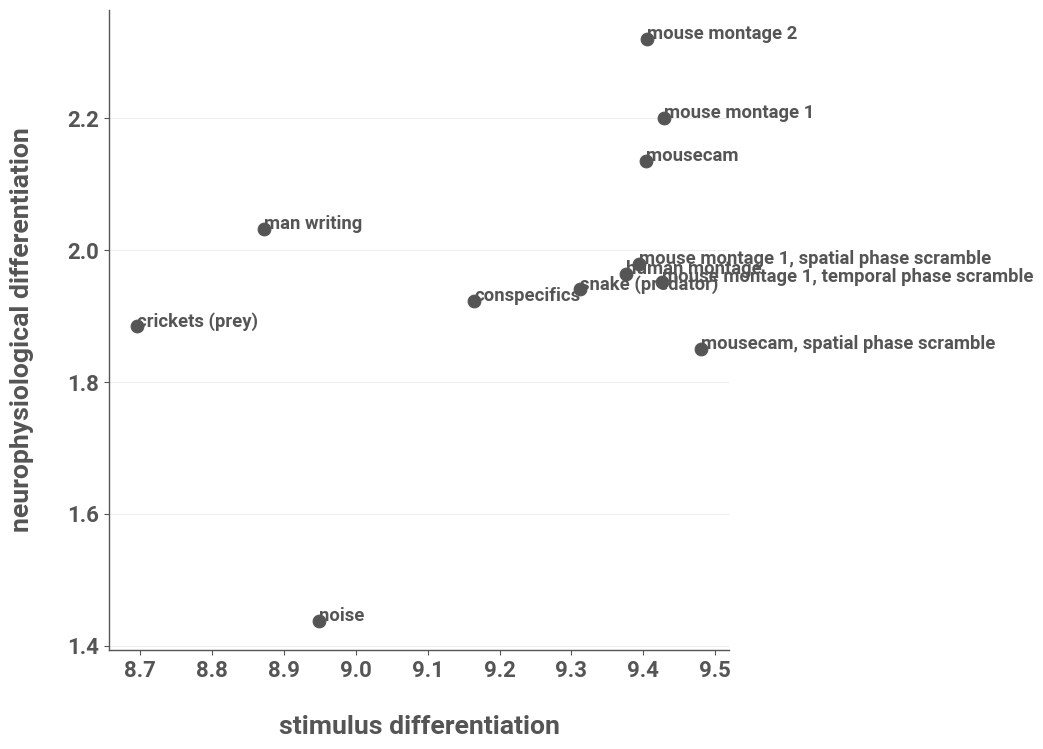

In [11]:
fig, ax = plot_stimulus_property(data, x, y)
ax.set_xlabel("\nstimulus differentiation")
analysis.savefig(fig, OUTPUT_DIR / "fig-8/nd_vs_stimulus_differentiation")

### Correlation

In [12]:
df = data.groupby("stimulus").mean().loc[:, [x, y]]
df

,log(stimulus differentiation),log(normalized differentiation)
stimulus,,
conspecifics,9.164791,1.923011
crickets (prey),8.695978,1.884264
human montage,9.375808,1.963054
man writing,8.872316,2.031114
mouse montage 1,9.428050,2.199659
"mouse montage 1, spatial phase scramble",9.394558,1.979156
"mouse montage 1, temporal phase scramble",9.426499,1.952077
mouse montage 2,9.404407,2.319619
mousecam,9.403705,2.135238


In [13]:
%%R -i df -i x -i response

x = df[[x]]
y = df[[response]]

print(cor.test(x, y, method="pearson", alternative="greater"))


	Pearson's product-moment correlation

data:  x and y
t = 1.5737, df = 10, p-value = 0.07331
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 -0.06905385  1.00000000
sample estimates:
      cor 
0.4455391 



### Noise stimulus has high influence

In [14]:
formula = f"`{response}` ~ `{x}`"
formula

'`log(normalized differentiation)` ~ `log(stimulus differentiation)`'

In [15]:
%%R -i data -i formula -o cooks_d

model = lm(formula, data=df)
cooks_d = cooks.distance(model)
cooks_d = tidy(cooks_d)

In [16]:
cooks_d = (
    cooks_d
    .rename(columns=dict(x="Cook's d"))
    .sort_values("Cook's d", ascending=False)
)
cooks_d

,names,Cook's d
11,noise,0.665396
2,crickets (prey),0.299606
4,man writing,0.237765
8,mouse montage 2,0.157368
10,"mousecam, spatial phase scramble",0.114746
5,mouse montage 1,0.055108
9,mousecam,0.021372
7,"mouse montage 1, temporal phase scramble",0.014437
3,human montage,0.004782
12,snake (predator),0.003763


### Correlation without noise stimulus

In [17]:
subset = df.loc[df.index != "noise"]

In [18]:
%%R -i subset -i x -i response

x = subset[[x]]
y = subset[[response]]

print(cor.test(x, y, method="pearson", alternative="greater"))


	Pearson's product-moment correlation

data:  x and y
t = 0.90752, df = 9, p-value = 0.1939
alternative hypothesis: true correlation is greater than 0
95 percent confidence interval:
 -0.2761141  1.0000000
sample estimates:
      cor 
0.2895481 



### Correlation among controlled stimuli

In [19]:
subset = df.loc[df.index.isin(UNSCRAMBLED_SCRAMBLED)]

In [20]:
%%R -i subset -i x -i response

x = subset[[x]]
y = subset[[response]]

print(cor.test(x, y, method="pearson", alternative="two.sided"))


	Pearson's product-moment correlation

data:  x and y
t = -1.1037, df = 3, p-value = 0.3503
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9630515  0.6558195
sample estimates:
       cor 
-0.5373777 



## Figure S10

PosixPath('figures/fig-s10/nd_vs_stimulus_properties.svg')

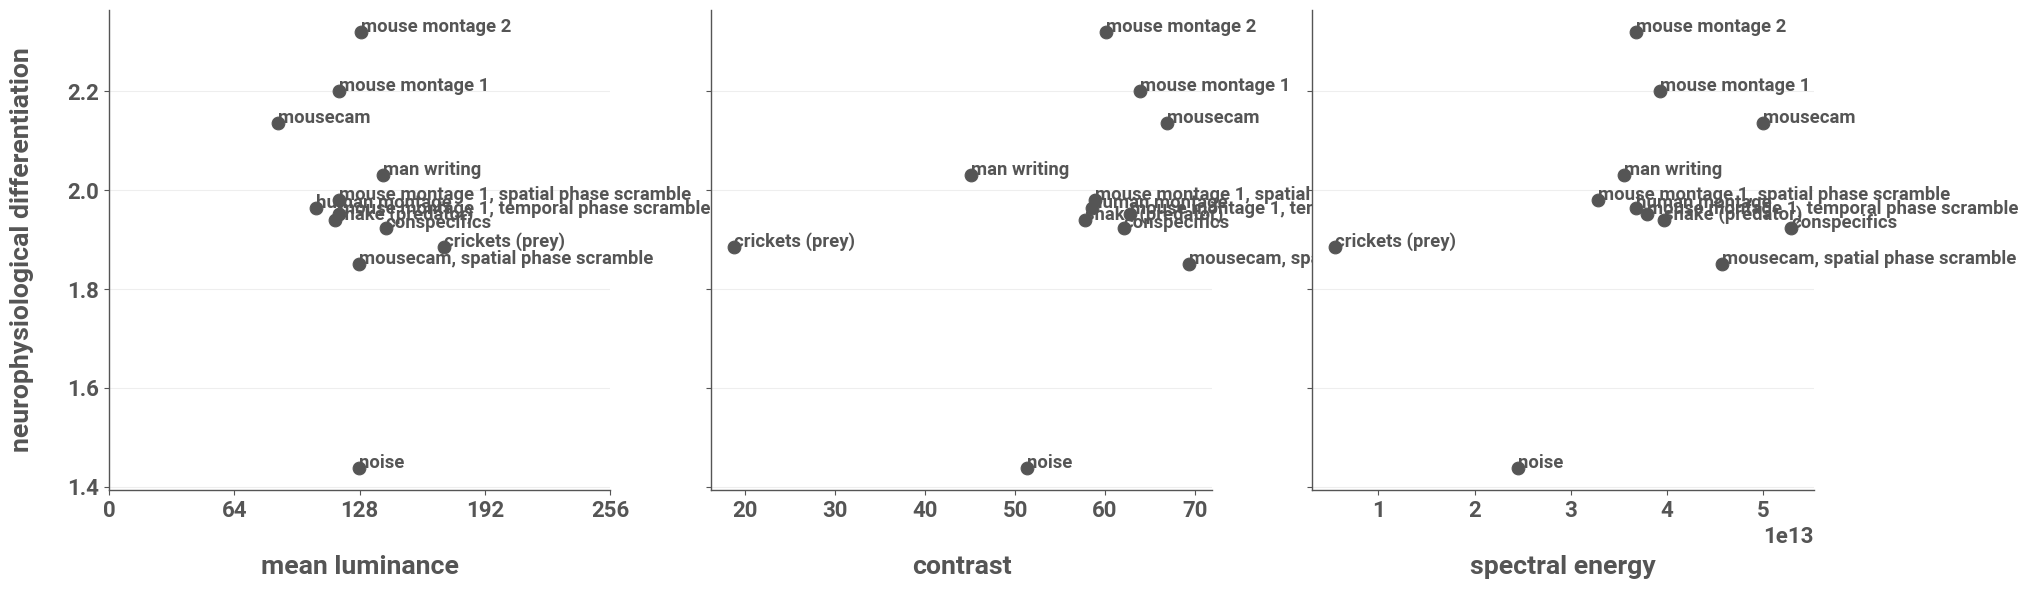

In [21]:
fig, grid = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(22, 6))

x = "mean luminance"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[0])

x = "contrast"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[1])
ax.set_ylabel("")

x = "spectral energy"
fig, ax = plot_stimulus_property(data, x, y, fig=fig, ax=grid[2])
ax.set_ylabel("")

analysis.savefig(fig, OUTPUT_DIR / "fig-s10/nd_vs_stimulus_properties")